## Setup

In [ ]:
ls

sample_data/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)


In [ ]:
cache_dir = Path(Path.home()) / "/content/drive/MyDrive/"
anchor_images_path = cache_dir / "input_images"
positive_images_path = cache_dir / "predicted_images"

In [ ]:

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [ ]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
# train_dataset = dataset.take(round(image_count * 0.8))
# val_dataset = dataset.skip(round(image_count * 0.8))

# train_dataset = train_dataset.batch(32, drop_remainder=False)
# train_dataset = train_dataset.prefetch(8)

# val_dataset = val_dataset.batch(32, drop_remainder=False)
# val_dataset = val_dataset.prefetch(8)

train_size = round(image_count * 0.7)
val_size = round(image_count * 0.1)
test_size = round(image_count * 0.2)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Batch and prefetch the datasets
batch_size = 32

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

test_dataset = test_dataset.batch(batch_size, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)



In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>

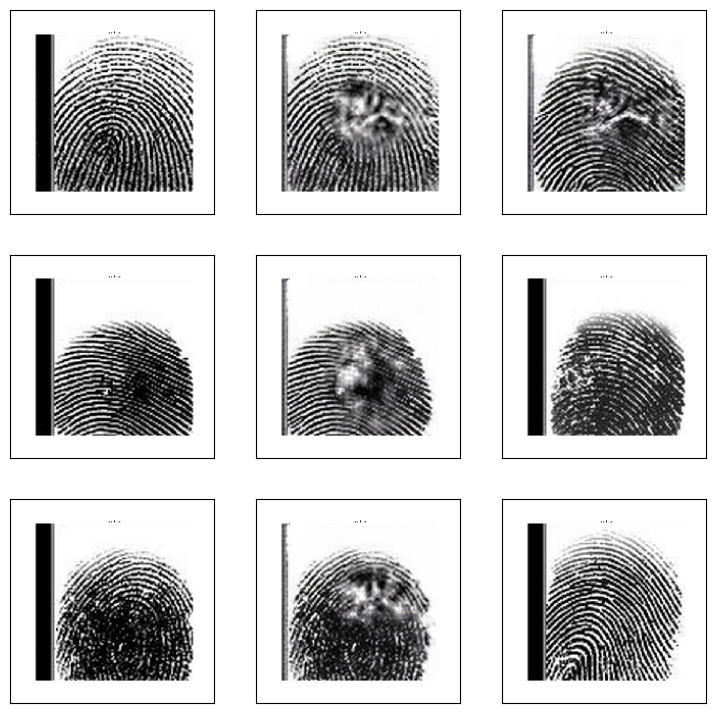

In [ ]:

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization,MaxPool2D

def get_encoder(input_shape):
    """ Returns the image encoding model """

    base_cnn = resnet.ResNet50(
        weights="imagenet",
        input_shape=target_shape + (3,),
        include_top=False
    )

    encode_model = Sequential([
        base_cnn,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(256)
    ], name="Encode_Model")

    return encode_model


In [ ]:
input_shape=(128, 128, 3)
encoder = get_encoder(input_shape)
encoder.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               

In [ ]:
# base_cnn = resnet.ResNet50(
#     weights="imagenet", input_shape=target_shape + (3,), include_top=False
# )

# flatten = layers.Flatten()(base_cnn.output)
# dense1 = layers.Dense(512, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(256, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)
# output = layers.Dense(256)(dense2)

# embedding = Model(base_cnn.input, output, name="Embedding")

# trainable = False
# for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":
#         trainable = True
#     layer.trainable = trainable

In [ ]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# distances = DistanceLayer()(
#     embedding(resnet.preprocess_input(anchor_input)),
#     embedding(resnet.preprocess_input(positive_input)),
#     embedding(resnet.preprocess_input(negative_input)),
# )

distances = DistanceLayer()(
    encoder(resnet.preprocess_input(anchor_input)),
    encoder(resnet.preprocess_input(positive_input)),
    encoder(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.acc_tracker = metrics.Mean(name="accuracy")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            acc = self._compute_acc(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(),"accuracy": self.acc_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        acc = self._compute_acc(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    def _compute_acc(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance, dtype=tf.float32))
        return accuracy

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history = siamese_model.fit(train_dataset, epochs=50, validation_data=val_dataset)
siamese_model.save_weights("siamese_model-final")

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.8854

3/3 [==============================] - 63s 6s/step - loss: 0.4801 - accuracy: 0.8854 - val_loss: 0.1744 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.8924

3/3 [==============================] - 15s 6s/step - loss: 0.1237 - accuracy: 0.8924 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.8715

3/3 [==============================] - 14s 5s/step - loss: 0.1698 - accuracy: 0.8715 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9688

3/3 [==============================] - 15s 6s/step - loss: 0.1364 - accuracy: 0.9688 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
3/3 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9792

3/3 [==============================] - 16s 7s/step - loss: 0.0465 - accuracy: 0.9792 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9375

3/3 [==============================] - 15s 6s/step - loss: 0.1661 - accuracy: 0.9375 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9167

3/3 [==============================] - 16s 6s/step - loss: 0.1452 - accuracy: 0.9167 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 8/50
3/3 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9792

3/3 [==============================] - 15s 5s/step - loss: 0.0924 - accuracy: 0.9792 - val_loss: 0.1008 - val_accuracy: 0.9000
Epoch 9/50
3/3 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9896

3/3 [==============================] - 14s 6s/step - loss: 0.0395 - accuracy: 0.9896 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/50
3/3 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.8924

3/3 [==============================] - 15s 6s/step - loss: 0.1390 - accuracy: 0.8924 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 11/50
3/3 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9792

3/3 [==============================] - 14s 5s/step - loss: 0.0608 - accuracy: 0.9792 - val_loss: 0.0366 - val_accuracy: 1.0000
Epoch 12/50
3/3 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9583

3/3 [==============================] - 15s 6s/step - loss: 0.0995 - accuracy: 0.9583 - val_loss: 0.0831 - val_accuracy: 0.9000
Epoch 13/50
3/3 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9132

3/3 [==============================] - 15s 6s/step - loss: 0.0857 - accuracy: 0.9132 - val_loss: 0.2417 - val_accuracy: 0.9000
Epoch 14/50
3/3 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9132

3/3 [==============================] - 16s 6s/step - loss: 0.0625 - accuracy: 0.9132 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 15/50
3/3 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9583

3/3 [==============================] - 17s 6s/step - loss: 0.0518 - accuracy: 0.9583 - val_loss: 0.0525 - val_accuracy: 0.9000
Epoch 16/50
3/3 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9896

3/3 [==============================] - 15s 6s/step - loss: 0.0244 - accuracy: 0.9896 - val_loss: 0.1008 - val_accuracy: 0.9000
Epoch 17/50
3/3 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9375

3/3 [==============================] - 14s 5s/step - loss: 0.1121 - accuracy: 0.9375 - val_loss: 0.1453 - val_accuracy: 0.9000
Epoch 18/50
3/3 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9583

3/3 [==============================] - 17s 7s/step - loss: 0.1414 - accuracy: 0.9583 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 19/50
3/3 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9062

3/3 [==============================] - 15s 6s/step - loss: 0.1643 - accuracy: 0.9062 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 20/50
3/3 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9896

3/3 [==============================] - 17s 7s/step - loss: 0.0205 - accuracy: 0.9896 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 21/50
3/3 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9896

3/3 [==============================] - 14s 5s/step - loss: 0.1873 - accuracy: 0.9896 - val_loss: 0.1995 - val_accuracy: 0.8000
Epoch 22/50
3/3 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9479

3/3 [==============================] - 15s 6s/step - loss: 0.2501 - accuracy: 0.9479 - val_loss: 0.0866 - val_accuracy: 1.0000
Epoch 23/50
3/3 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9236

3/3 [==============================] - 15s 6s/step - loss: 0.1232 - accuracy: 0.9236 - val_loss: 0.1552 - val_accuracy: 0.9000
Epoch 24/50
3/3 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9375

3/3 [==============================] - 16s 7s/step - loss: 0.1692 - accuracy: 0.9375 - val_loss: 0.1221 - val_accuracy: 0.9000
Epoch 25/50
3/3 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9271

3/3 [==============================] - 17s 7s/step - loss: 0.1230 - accuracy: 0.9271 - val_loss: 0.0822 - val_accuracy: 0.9000
Epoch 26/50
3/3 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9167

3/3 [==============================] - 17s 6s/step - loss: 0.1513 - accuracy: 0.9167 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 27/50
3/3 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9375

3/3 [==============================] - 16s 7s/step - loss: 0.1206 - accuracy: 0.9375 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 28/50
3/3 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9028

3/3 [==============================] - 15s 6s/step - loss: 0.0925 - accuracy: 0.9028 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 29/50
3/3 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9479

3/3 [==============================] - 16s 7s/step - loss: 0.0821 - accuracy: 0.9479 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 30/50
3/3 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9792

3/3 [==============================] - 16s 6s/step - loss: 0.0245 - accuracy: 0.9792 - val_loss: 0.1735 - val_accuracy: 0.9000
Epoch 31/50
3/3 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9688

3/3 [==============================] - 16s 7s/step - loss: 0.1455 - accuracy: 0.9688 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 32/50
3/3 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9688

3/3 [==============================] - 14s 5s/step - loss: 0.0664 - accuracy: 0.9688 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 33/50
3/3 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.8576

3/3 [==============================] - 16s 6s/step - loss: 0.1594 - accuracy: 0.8576 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 34/50
3/3 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9583

3/3 [==============================] - 16s 7s/step - loss: 0.0460 - accuracy: 0.9583 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 35/50
3/3 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9792

3/3 [==============================] - 14s 5s/step - loss: 0.0352 - accuracy: 0.9792 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 36/50
3/3 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9583

3/3 [==============================] - 13s 5s/step - loss: 0.0591 - accuracy: 0.9583 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 37/50
3/3 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9236

3/3 [==============================] - 14s 5s/step - loss: 0.0489 - accuracy: 0.9236 - val_loss: 0.0282 - val_accuracy: 1.0000
Epoch 38/50
3/3 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9688

3/3 [==============================] - 15s 6s/step - loss: 0.0756 - accuracy: 0.9688 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 39/50
3/3 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9688

3/3 [==============================] - 16s 6s/step - loss: 0.0695 - accuracy: 0.9688 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 40/50
3/3 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9688

3/3 [==============================] - 16s 6s/step - loss: 0.0882 - accuracy: 0.9688 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 41/50
3/3 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9896

3/3 [==============================] - 14s 5s/step - loss: 0.0860 - accuracy: 0.9896 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 42/50
3/3 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9479

3/3 [==============================] - 16s 7s/step - loss: 0.0896 - accuracy: 0.9479 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 43/50
3/3 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9583

3/3 [==============================] - 15s 6s/step - loss: 0.0745 - accuracy: 0.9583 - val_loss: 0.0551 - val_accuracy: 0.9000
Epoch 44/50
3/3 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9688

3/3 [==============================] - 13s 5s/step - loss: 0.0619 - accuracy: 0.9688 - val_loss: 0.0500 - val_accuracy: 0.9000
Epoch 45/50
3/3 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9236

3/3 [==============================] - 14s 5s/step - loss: 0.0457 - accuracy: 0.9236 - val_loss: 0.0877 - val_accuracy: 0.9000
Epoch 46/50
3/3 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9236

3/3 [==============================] - 15s 6s/step - loss: 0.0429 - accuracy: 0.9236 - val_loss: 0.0640 - val_accuracy: 1.0000
Epoch 47/50
3/3 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9375

3/3 [==============================] - 17s 6s/step - loss: 0.1370 - accuracy: 0.9375 - val_loss: 0.2354 - val_accuracy: 0.8000
Epoch 48/50
3/3 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.8819

3/3 [==============================] - 16s 7s/step - loss: 0.1081 - accuracy: 0.8819 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 49/50
3/3 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9340

3/3 [==============================] - 16s 6s/step - loss: 0.0283 - accuracy: 0.9340 - val_loss: 0.0492 - val_accuracy: 1.0000
Epoch 50/50
3/3 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9271

3/3 [==============================] - 16s 6s/step - loss: 0.1876 - accuracy: 0.9271 - val_loss: 0.1531 - val_accuracy: 0.8000


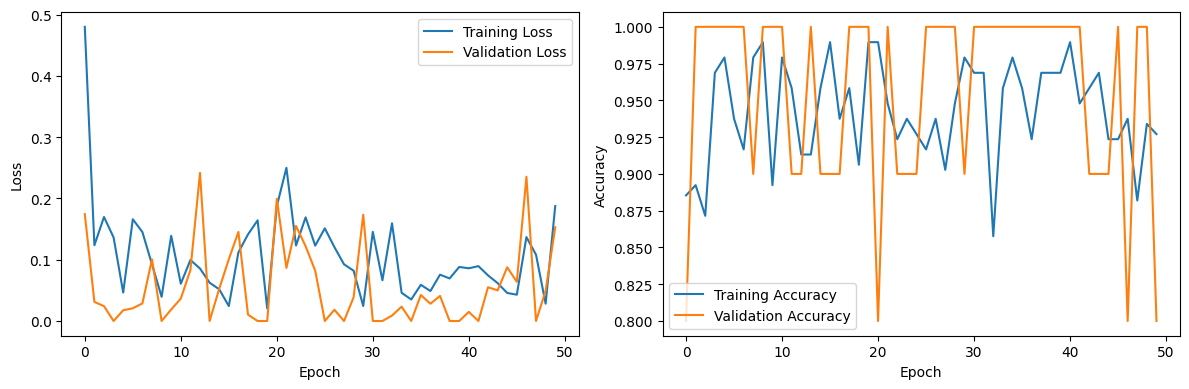

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    encoder(resnet.preprocess_input(anchor)),
    encoder(resnet.preprocess_input(positive)),
    encoder(resnet.preprocess_input(negative)),
)

NameError: ignored

Finally, we can compute the cosine similarity between the anchor and positive
images and compare it with the similarity between the anchor and the negative
images.

We should expect the similarity between the anchor and positive images to be
larger than the similarity between the anchor and the negative images.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

anchor_embedding = np.array(anchor_embedding)  # Convert to NumPy arrays if not already
positive_embedding = np.array(positive_embedding)
negative_embedding = np.array(negative_embedding)

euclidean_distance = euclidean_distances(anchor_embedding.reshape(1, -1), positive_embedding.reshape(1, -1))
print("Positive Euclidean distance:", euclidean_distance[0][0])

euclidean_distance = euclidean_distances(anchor_embedding.reshape(1, -1), negative_embedding.reshape(1, -1))
print("Negative Euclidean distance:", euclidean_distance[0][0])

Positive Euclidean distance: 9.254971
Negative Euclidean distance: 42.531708


In [ ]:
# def extract_encoder(model):
#     encoder = get_encoder((128, 128, 3))
#     i=0
#     for e_layer in model.layers[0].layers[3].layers:
#         layer_weight = e_layer.get_weights()
#         encoder.layers[i].set_weights(layer_weight)
#         i+=1
#     return encoder

# encoder = extract_encoder(siamese_model)
# encoder.save_weights("encoder")

In [ ]:
def classify_images(face_list1, face_list2, threshold=20):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


1/1 [==============================] - 0s 29ms/step

Accuracy of model: 0.8

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        30
           1       1.00      0.60      0.75        30

    accuracy                           0.80        60
   macro avg       0.86      0.80      0.79        60
weighted avg       0.86      0.80      0.79        60



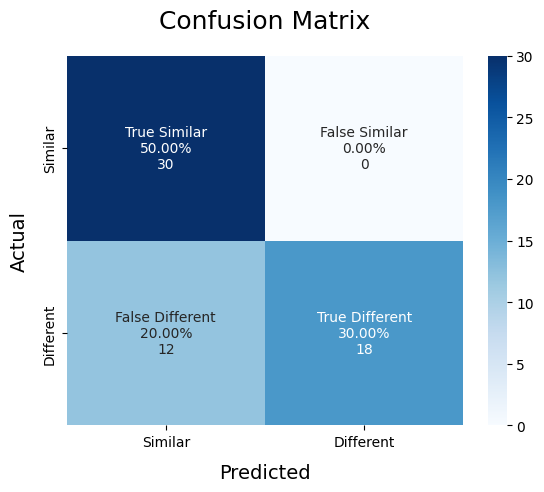

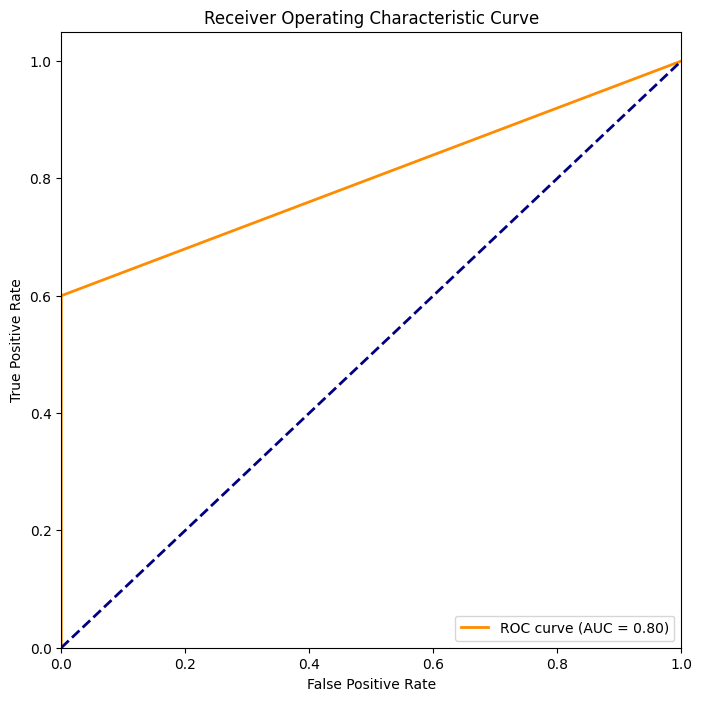

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# save_all = True

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)
    print(classification_report(true, pred))

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    counts = [str(value) for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}\n{n}' for v1, v2, n in zip(names, percentages, counts)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # Compute ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


pos_list = np.array([])
neg_list = np.array([])

for data in test_dataset:
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break


ModelMetrics(pos_list, neg_list)